# TP 3  : Graph Neural Networks Architecture

**Théo Rudkiewicz, Cyriaque Rousselot**

# TUTORIAL

### Install Pytorch Geometric

To handle graph data, we use the library Pytorch Geometric : https://pytorch-geometric.readthedocs.io/en/latest/

*   If you use _Google Colab_, simply run the following cell to install Pytorch Geometric (**advised**).
*   If you plan using your _own environment_, follow the documentation to install Pytorch Geometric : https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html and skip the following cell.

In [1]:
########## INSTALL TORCH GEOMETRIC ##################
# https://pytorch-geometric.readthedocs.io/en/latest/
#####################################################
import torch


def format_pytorch_version(version):
    return version.split("+")[0]


TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)


def format_cuda_version(version):
    return "cu" + version.replace(".", "")


CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric


Looking in links: https://pytorch-geometric.com/whl/torch-2.5.1+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 26.1 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.5.1+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 17.6 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.5.1+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 61.6 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.5.1+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.7 MB/s eta 0:00:00


### Import required packages

Run the following cell to import all required packages. This cell **must not** be modified.

To significantly accelerate your training, it is advised to use GPU. Using Google Colab, you need to activate it :

*   Edit --> Notebook Setting --> Hardware accelerator --> GPU

In [2]:
#####################################################
################## PACKAGES #########################
#####################################################
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch_geometric.nn as graphnn
from sklearn.metrics import f1_score
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader

### Dataset

We use the Protein-Protein Interaction (PPI) network dataset which includes:
- 20 graphs for training
- 2 graphs for validation
- 2 graphs for testing

One graph of the PPI dataset has on average 2372 nodes. Each node has:
- 50 features : positional gene sets / motif gene / immunological signatures ...
- 121 (binary) labels : gene ontology sets (way to classify gene products like proteins).

**This problem aims to predict, for a given PPI graph, the correct nodes' labels**.

**It is a node (multi-label) classification task** (trained using supervised learning, with labels to be predicted for each node).

For your curiosity, more detailed information on the dataset and some applications:
- https://cs.stanford.edu/~jure/pubs/pathways-psb18.pdf
- https://arxiv.org/abs/1707.04638

To understand how a graph data is implemented in Pytorch Geometric, refer to : https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html


In [3]:
### LOAD DATASETS

BATCH_SIZE = 2

# Train Dataset
train_dataset = PPI(root="", split="train")
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
# Val Dataset
val_dataset = PPI(root="", split="val")
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
# Test Dataset
test_dataset = PPI(root="", split="test")
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Number of features and classes
n_features, n_classes = train_dataset[0].x.shape[1], train_dataset[0].y.shape[1]

print("Number of samples in the train dataset: ", len(train_dataset))
print("Number of samples in the val dataset: ", len(test_dataset))
print("Number of samples in the test dataset: ", len(test_dataset))
print("Output of one sample from the train dataset: ", train_dataset[0])
print("Edge_index :")
print(train_dataset[0].edge_index)
print("Number of features per node: ", n_features)
print("Number of classes per node: ", n_classes)

Extracting ./ppi.zip
Processing...
/usr/local/lib/python3.11/dist-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(


Number of samples in the train dataset:  20
Number of samples in the val dataset:  2
Number of samples in the test dataset:  2
Output of one sample from the train dataset:  Data(x=[1767, 50], edge_index=[2, 32318], y=[1767, 121])
Edge_index :
tensor([[   0,    0,    0,  ..., 1744, 1745, 1749],
        [ 372, 1101,  766,  ..., 1745, 1744, 1739]])
Number of features per node:  50
Number of classes per node:  121


Done!


### Define a basic Model

Here we define a very simple Graph Neural Network model which will be used as our baseline. This model consists of three graph convolutional layers (from https://arxiv.org/pdf/1609.02907.pdf). The first two layers computes 256 features, followed by an ELU activation function. The last layer is used for (multi-label) classification task, computing 121 features (for each node).

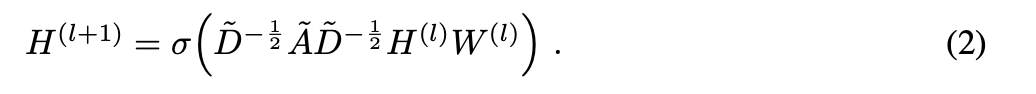

In [4]:
#####################################################
################## MODEL ############################
#####################################################
class BasicGraphModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.graphconv1 = graphnn.GCNConv(input_size, hidden_size)
        self.graphconv2 = graphnn.GCNConv(hidden_size, hidden_size)
        self.graphconv3 = graphnn.GCNConv(hidden_size, output_size)

        self.elu = nn.ELU()

    def forward(self, x, edge_index):
        x = self.graphconv1(x, edge_index)
        x = self.elu(x)
        x = self.graphconv2(x, edge_index)
        x = self.elu(x)
        x = self.graphconv3(x, edge_index)

        return x

Next function is designed to evaluate the performance of the model, computing the F1-Score

In [5]:
#####################################################
############### TEST FUNCTION #######################
#####################################################
def evaluate(model, loss_fcn, device, dataloader):
    score_list_batch = []

    model.eval()
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        output = model(batch.x, batch.edge_index)
        loss_test = loss_fcn(output, batch.y)
        predict = np.where(output.detach().cpu().numpy() >= 0, 1, 0)
        score = f1_score(batch.y.cpu().numpy(), predict, average="micro")
        score_list_batch.append(score)

    return np.array(score_list_batch).mean()

Next we construct the function to train the model.

In [6]:
#####################################################
############## TRAIN FUNCTION #######################
#####################################################
def train(model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader):
    epoch_list = []
    scores_list = []

    # loop over epochs
    for epoch in range(max_epochs):
        model.train()
        losses = []
        # loop over batches
        for i, train_batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            train_batch_device = train_batch.to(device)
            # logits is the output of the model
            logits = model(train_batch_device.x, train_batch_device.edge_index)
            # compute the loss
            loss = loss_fcn(logits, train_batch_device.y)
            # optimizer step
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        loss_data = np.array(losses).mean()
        print("Epoch {:05d} | Loss: {:.4f}".format(epoch + 1, loss_data))

        if epoch % 5 == 0:
            # evaluate the model on the validation set
            # computes the f1-score (see next function)
            score = evaluate(model, loss_fcn, device, val_dataloader)
            print("F1-Score: {:.4f}".format(score))
            scores_list.append(score)
            epoch_list.append(epoch)

    return epoch_list, scores_list

Let's train this model !

In [7]:
### DEVICE GPU OR CPU : will select GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nDevice: ", device)

### Max number of epochs
max_epochs = 200

### DEFINE THE MODEL
basic_model = BasicGraphModel(input_size=n_features, hidden_size=256, output_size=n_classes).to(
    device
)

### DEFINE LOSS FUNCTION
loss_fcn = nn.BCEWithLogitsLoss()

### DEFINE OPTIMIZER
optimizer = torch.optim.Adam(basic_model.parameters(), lr=0.005)

### TRAIN THE MODEL
epoch_list, basic_model_scores = train(
    basic_model,
    loss_fcn,
    device,
    optimizer,
    max_epochs,
    train_dataloader,
    val_dataloader,
)


Device:  cuda
Epoch 00001 | Loss: 0.6384
F1-Score: 0.4545
Epoch 00002 | Loss: 0.5813
Epoch 00003 | Loss: 0.5629
Epoch 00004 | Loss: 0.5563
Epoch 00005 | Loss: 0.5515
Epoch 00006 | Loss: 0.5465
F1-Score: 0.4905
Epoch 00007 | Loss: 0.5422
Epoch 00008 | Loss: 0.5378
Epoch 00009 | Loss: 0.5345
Epoch 00010 | Loss: 0.5319
Epoch 00011 | Loss: 0.5291
F1-Score: 0.5276
Epoch 00012 | Loss: 0.5263
Epoch 00013 | Loss: 0.5238
Epoch 00014 | Loss: 0.5215
Epoch 00015 | Loss: 0.5192
Epoch 00016 | Loss: 0.5168
F1-Score: 0.5067
Epoch 00017 | Loss: 0.5144
Epoch 00018 | Loss: 0.5119
Epoch 00019 | Loss: 0.5095
Epoch 00020 | Loss: 0.5073
Epoch 00021 | Loss: 0.5053
F1-Score: 0.5326
Epoch 00022 | Loss: 0.5033
Epoch 00023 | Loss: 0.5013
Epoch 00024 | Loss: 0.4994
Epoch 00025 | Loss: 0.4974
Epoch 00026 | Loss: 0.4955
F1-Score: 0.5453
Epoch 00027 | Loss: 0.4936
Epoch 00028 | Loss: 0.4918
Epoch 00029 | Loss: 0.4900
Epoch 00030 | Loss: 0.4882
Epoch 00031 | Loss: 0.4865
F1-Score: 0.5569
Epoch 00032 | Loss: 0.4848
Ep

Let's evaluate the performance of this basic model

Basic Model : F1-Score on the validation set: 0.6391


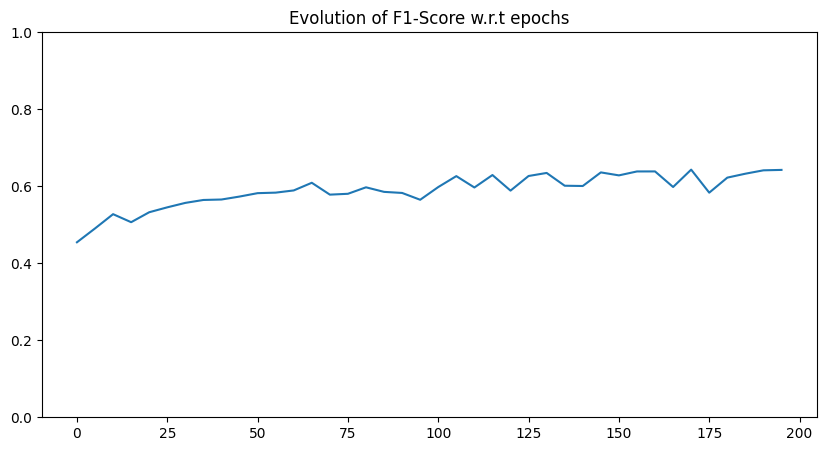

In [8]:
### F1-SCORE ON VALID DATASET
score_valid = evaluate(basic_model, loss_fcn, device, val_dataloader)
print("Basic Model : F1-Score on the validation set: {:.4f}".format(score_valid))


### PLOT EVOLUTION OF F1-SCORE W.R.T EPOCHS
def plot_f1_score(epoch_list, scores):
    plt.figure(figsize=[10, 5])
    plt.plot(epoch_list, scores)
    plt.title("Evolution of F1-Score w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.show()


plot_f1_score(epoch_list, basic_model_scores)

# QUESTIONS

## Grading

You will be graded on 5 questions. You will need to provide at least 4 files :
1. This Notebook
2. `class_model_gnn.py`
3. `model.pth` (the file **must be of size less than 50Mo** but 20Mo should be enough to get a very good model)
4. `conv_as_message_passing.py`

If the function you defined passes all the tests, you will get the full grade. Otherwise we  will look at the intermediate questions in the notebook to give you partial credit.



 Please provide clear, short and __bold font__ answers.  

> Question 1 : Design, build and train a model with a F1-score higher than 93% on validation set (**HINT :** https://arxiv.org/pdf/1710.10903.pdf).


 Provide two files : (https://pytorch.org/tutorials/beginner/saving_loading_models.html)
 -  a file  `class_model_gnn.py` containing the class inheriting from `torch.nn.Module` architecture of your final model to load
 -  a `model.pth` file : the model weights

 We will  test your model on final F1-Score on a test set. You must not use the test set for hyperparameter training.

Intermediate question :

 Provide the script for training, and a plot of the training loss.  

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# Define model ( in your class_model_gnn.py)
class StudentModel(nn.Module):
    def __init__(self):
        super(StudentModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Initialize model
model = StudentModel()

## Save the model
torch.save(model.state_dict(), "model.pth")


### This is the part we will run in the inference to grade your model
## Load the model
model = StudentModel()  # !  Important : No argument
model.load_state_dict(torch.load("model.pth", weights_only=True))
model.eval()
print("Model loaded successfully")


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.nn import GATConv

# ================================
# Model Definition: GAT-based Model
# ================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv


class StudentModel(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=256, heads_layer1=4, heads_layer2=4, heads_out=6, dropout=0.6):
        """
        :param in_channels:   输入特征维度
        :param out_channels:  输出特征维度（多标签任务 == 标签数）
        :param hidden_channels: 隐藏层每个注意力头输出维度
        :param heads_layer1:  第一层的注意力头数
        :param heads_layer2:  第二层的注意力头数
        :param heads_out:     最后一层的注意力头数
        :param dropout:       dropout 概率
        """
        super(StudentModel, self).__init__()

        # 第1层 GATConv
        # 每个头输出 hidden_channels, 有 heads_layer1 个头 -> 输出维度 = hidden_channels * heads_layer1
        self.gat1 = GATConv(in_channels, hidden_channels,
                            heads=heads_layer1,
                            dropout=dropout,
                            concat=True)  # 拼接

        # 第2层 GATConv
        # 输入维度 = hidden_channels * heads_layer1
        # 同样输出 hidden_channels, 有 heads_layer2 个头 -> 输出维度 = hidden_channels * heads_layer2
        self.gat2 = GATConv(hidden_channels * heads_layer1,
                            hidden_channels,
                            heads=heads_layer2,
                            dropout=dropout,
                            concat=True)  # 拼接

        # 第3层 GATConv (输出层)
        # 输入维度 = hidden_channels * heads_layer2
        # 注意这里 concat=False，则输出维度 = out_channels
        self.gat3 = GATConv(hidden_channels * heads_layer2,
                            out_channels,
                            heads=heads_out,
                            dropout=dropout,
                            concat=False)  # 不拼接, 而是对 heads_out 做平均

        self.elu = nn.ELU()
        self.dropout = dropout

    def forward(self, x, edge_index):
        """
        :param x:         [num_nodes, in_channels]
        :param edge_index: [2, num_edges], 存储图的边
        :return:          logits, shape = [num_nodes, out_channels]
        """
        # ----- 第1层 -----
        x1 = self.gat1(x, edge_index)     # -> [num_nodes, hidden_channels * heads_layer1]
        x1 = self.elu(x1)
        x1 = F.dropout(x1, p=self.dropout, training=self.training)

        # ----- 第2层 -----
        x2 = self.gat2(x1, edge_index)     # -> [num_nodes, hidden_channels * heads_layer2]
        x2 = self.elu(x2)
        x2 = F.dropout(x2, p=self.dropout, training=self.training)
        # ----- add skip connection -----

        x2 = x2 + x1
        # ----- 第3层（输出层）-----
        x3 = self.gat3(x2, edge_index)     # -> [num_nodes, out_channels]
        # 这里最后一般不加激活函数，直接返回 logits 给 BCEWithLogitsLoss
        # print('using new model')
        return x3


# ================================
# Training Script
# ================================
def train(model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader):
    epoch_list = []
    scores_list = []

    # loop over epochs
    for epoch in range(max_epochs):
        model.train()
        losses = []
        # loop over batches
        for i, train_batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            train_batch_device = train_batch.to(device)
            # logits is the output of the model
            logits = model(train_batch_device.x, train_batch_device.edge_index)
            # compute the loss
            loss = loss_fcn(logits, train_batch_device.y)
            # optimizer step
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        loss_data = np.array(losses).mean()
        print("Epoch {:05d} | Loss: {:.4f}".format(epoch + 1, loss_data))

        if epoch % 5 == 0:
            # evaluate the model on the validation set
            # computes the f1-score (see next function)
            score = evaluate(model, loss_fcn, device, val_dataloader)
            print("F1-Score: {:.4f}".format(score))
            scores_list.append(score)
            epoch_list.append(epoch)

    return epoch_list, scores_list

def plot_loss(loss_history):
    plt.figure(figsize=(10, 6))
    plt.plot(loss_history, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss over Epochs")
    plt.legend()
    plt.show()

# ================================
# 主程序入口
# ================================
# 根据你的实际情况设置设备、数据和模型参数
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

# 假设你已经定义了数据加载器和相关参数：
# 例如：
# n_features = 数据中每个节点的特征维度
# n_classes  = 目标标签数（多标签问题时，每个标签是二元的）
# n_features = 100    # 示例：实际请替换为你的特征数
# n_classes = 121     # 示例：多标签时每个节点121维标签

# 初始化模型
model = StudentModel(
    in_channels=n_features,
    out_channels=n_classes,
    hidden_channels=256,
    heads_layer1=4,
    heads_layer2=4,
    heads_out=6,
    dropout=0.4
).to(device)

# 定义损失函数（多标签任务用 BCEWithLogitsLoss）
loss_fcn = nn.BCEWithLogitsLoss()

# 定义优化器
optimizer = optim.Adam(model.parameters(), lr=0.005)

# 假设 train_dataloader 已经定义并加载好训练数据
# 例如：
# from torch_geometric.data import DataLoader
# train_dataset = ...   # 你的训练数据集
# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 开始训练
num_epochs = 200
epoch_list, basic_model_scores = train(
    model,
    loss_fcn,
    device,
    optimizer,
    num_epochs,train_dataloader,val_dataloader)

# 保存模型权重
# torch.save(model.state_dict(), "model.pth")
print("Model weights saved to model.pth")

# 绘制训练损失曲线
# plot_loss(loss_history)


Device:  cuda
Epoch 00001 | Loss: 0.7306
F1-Score: 0.4243
Epoch 00002 | Loss: 0.5730
Epoch 00003 | Loss: 0.5503
Epoch 00004 | Loss: 0.5382
Epoch 00005 | Loss: 0.5281
Epoch 00006 | Loss: 0.5277
F1-Score: 0.4729
Epoch 00007 | Loss: 0.5201
Epoch 00008 | Loss: 0.5162
Epoch 00009 | Loss: 0.5139
Epoch 00010 | Loss: 0.5086
Epoch 00011 | Loss: 0.5083
F1-Score: 0.4686
Epoch 00012 | Loss: 0.5095
Epoch 00013 | Loss: 0.5047
Epoch 00014 | Loss: 0.5014
Epoch 00015 | Loss: 0.5004
Epoch 00016 | Loss: 0.5018
F1-Score: 0.5349
Epoch 00017 | Loss: 0.4973
Epoch 00018 | Loss: 0.4955
Epoch 00019 | Loss: 0.4948
Epoch 00020 | Loss: 0.4954
Epoch 00021 | Loss: 0.4936
F1-Score: 0.5760
Epoch 00022 | Loss: 0.4899
Epoch 00023 | Loss: 0.4865
Epoch 00024 | Loss: 0.4871
Epoch 00025 | Loss: 0.4868
Epoch 00026 | Loss: 0.4858
F1-Score: 0.5931
Epoch 00027 | Loss: 0.4835
Epoch 00028 | Loss: 0.4876
Epoch 00029 | Loss: 0.4844
Epoch 00030 | Loss: 0.4804
Epoch 00031 | Loss: 0.4814
F1-Score: 0.5456
Epoch 00032 | Loss: 0.4812
Epo

## Conv 2D as Message Passing Neural Network


## Introduction

The use of graph is a way to structure data by adding neighborhood information between features. This then allows to do operations on the data that are local to each node and its neighbors. This is the main idea behind Graph Neural Networks (GNNs). [`pytorch-geometric`](https://pytorch-geometric.readthedocs.io/en/latest/) is a library compatible with PyTorch that allows to easily implement GNNs. The most general structure is the [`MessagePassing`](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.MessagePassing.html#torch_geometric.nn.conv.MessagePassing) class that is then used as a base for more specific GNNs as seen in the course ([Graph Convolutional Networks](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GCNConv.html#torch_geometric.nn.conv.GCNConv) or [Graph AttenTion Convolution](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GATConv.html#torch_geometric.nn.conv.GATConv)).

On the other hand, you already know an operation that uses the structure of the data to do local operations: the convolution (https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html). One can see the convolution as a specific case of the message passing neural network. The goal of this notebook is to show how to use the `MessagePassing` class to implement a convolutional neural network.
You will be asked to implement 3 functions. You should give back those three functions in a file named `conv_as_message_passing.py`. These functions will then be automatically tested. So be sure to respect the function signature and the function name.


## Assumptions

To make the implementation easier we will make some assumptions:
- the input is a single image (batch size of 1) of size 'C x H x W'
- the convolution will be a 3x3 kernel with stride 1 and padding 1.

You may also assume that the Conv2D layer has no bias but it will be slightly penalized in the grading.

Bonus points will be given if you can handle the cases that are not covered by those assumptions.


## Questions

### Question 2

> Using the formalism used in the [`MessagePassing`](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.MessagePassing.html#torch_geometric.nn.conv.MessagePassing) documentation (and on [wikipedia](https://en.wikipedia.org/wiki/Graph_neural_network#Message_passing_layers) with sligthly different notations), explain how theorically you can simulate a 2D convolution using the `MessagePassing` formalism. This may include a pre-processing step to transform the image into a graph and then a post-processing step to transform the graph back into an image. (:warning: Those steps should be independent of the parameters of the convolution, but not necessarily from the hyper-parameters.)
$$\mathbf{x}_{i}^{\prime} = \gamma_{\mathbf{\Theta}}\left( \mathbf{x}_{i},\bigoplus\limits_{j \in \mathcal{N}(i)}\,\phi_{\mathbf{\Theta}}\left( \mathbf{x}_{i},\mathbf{x}_{j},\mathbf{e}_{j,i} \right) \right),$$


HINT : It is possible to do it with the following $\gamma$ :

$$ \gamma_\Theta : x,y \mapsto y $$


In [ ]:
import torch
import torch_geometric

### Question 3

> Implement the pre-processing function, you can use the follwing code skeleton (you may change the output type, it is just a strong suggestion):

In [ ]:
def image_to_graph(
    image: torch.Tensor, conv2d: torch.nn.Conv2d | None = None
) -> torch_geometric.data.Data:
    """
    Converts an image tensor to a PyTorch Geometric Data object.
    COMPLETE

    Arguments:
    ----------
    image : torch.Tensor
        Image tensor of shape (C, H, W).
    conv2d : torch.nn.Conv2d, optional
        Conv2d layer to simulate, by default None
        Is used to determine the size of the receptive field.

    Returns:
    --------
    torch_geometric.data.Data
        Graph representation of the image.
    """
    # Assumptions (remove it for the bonus)
    assert image.dim() == 3, f"Expected 3D tensor, got {image.dim()}D tensor."
    if conv2d is not None:
        assert conv2d.padding[0] == conv2d.padding[1] == 1, "Expected padding of 1 on both sides."
        assert conv2d.kernel_size[0] == conv2d.kernel_size[1] == 3, "Expected kernel size of 3x3."
        assert conv2d.stride[0] == conv2d.stride[1] == 1, "Expected stride of 1."

    raise NotImplementedError

### Question 4

> Implement the post-processing function, you can use the follwing code skeleton:

In [ ]:
def graph_to_image(
    data: torch.Tensor, height: int, width: int, conv2d: torch.nn.Conv2d | None = None
) -> torch.Tensor:
    """
    Converts a graph representation of an image to an image tensor.

    Arguments:
    ----------
    data : torch.Tensor
        Graph data representation of the image.
    height : int
        Height of the image.
    width : int
        Width of the image.
    conv2d : torch.nn.Conv2d, optional
        Conv2d layer to simulate, by default None

    Returns:
    --------
    torch.Tensor
        Image tensor of shape (C, H, W).
    """
    # Assumptions (remove it for the bonus)
    assert data.dim() == 2, f"Expected 2D tensor, got {data.dim()}D tensor."
    if conv2d is not None:
        assert conv2d.padding[0] == conv2d.padding[1] == 1, "Expected padding of 1 on both sides."
        assert conv2d.kernel_size[0] == conv2d.kernel_size[1] == 3, "Expected kernel size of 3x3."
        assert conv2d.stride[0] == conv2d.stride[1] == 1, "Expected stride of 1."

    raise NotImplementedError

#### Recommended test cases

We **encourage** you to test that you have the property that the pre-processing function followed by the post-processing function is the identity function.

In [ ]:
ref_conv = torch.nn.Conv2d(5, 7, kernel_size=3, padding=1, stride=1)
image = torch.randn(5, 10, 11)
g_image = image_to_graph(image, ref_conv)
reconstructed_image = graph_to_image(g_image.x, 10, 11, ref_conv)
assert torch.allclose(image, reconstructed_image)

### Question 5

> Implement the `Conv2dMessagePassing` class that will simulate a 2D convolution using the `MessagePassing` formalism.
You should inherit from the `MessagePassing` class and only change the `__init__` and `message` functions (the `forward` function has already been changed for you). You should use the following code skeleton:

In [ ]:
class Conv2dMessagePassing(torch_geometric.nn.MessagePassing):
    """
    A Message Passing layer that simulates a given Conv2d layer.
    """

    def __init__(self, conv2d: torch.nn.Conv2d):
        # <TO IMPLEMENT>
        # Don't forget to call the parent constructor with the correct aguments
        # super().__init__(<arguments>)
        # </TO IMPLEMENT>
        raise NotImplementedError

    def forward(self, data):
        self.edge_index = data.edge_index

        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        out = self.propagate(edge_index, x=x, edge_attr=edge_attr)
        return out

    def message(self, x_j: torch.Tensor, edge_attr: torch.Tensor) -> torch.Tensor:
        """
        Computes the message to be passed for each edge.
        For each edge e = (u, v) in the graph indexed by i,
        the message trough the edge e (ie from node u to node v)
        should be returned as the i-th line of the output tensor.
        (The message is phi(u, v, e) in the formalism.)
        To do this you can access the features of the source node
        in x_j[i] and the attributes of the edge in edge_attr[i].

        Arguments:
        ----------
        x_j : torch.Tensor
            The features of the souce node for each edge (of size E x in_channels).
        edge_attr : torch.Tensor
            The attributes of the edge (of size E x edge_attr_dim).

        Returns:
        --------
        torch.Tensor
            The message to be passed for each edge (of size COMPLETE)
        """
        raise NotImplementedError


## Test example

In [ ]:
from conv_as_message_passing import image_to_graph, graph_to_image, Conv2dMessagePassing

c = 5
h = 10
w = 11

ref_conv = torch.nn.Conv2d(c, 2, kernel_size=3, padding=1, stride=1, bias=False)
image = torch.randn(c, h, w)
g_image = image_to_graph(image, ref_conv)
ref_conv.weight.data = torch.randn_like(ref_conv.weight.data)

conv_mp = Conv2dMessagePassing(ref_conv)
g_image = conv_mp(g_image)

y_th = ref_conv(image)

ref_conv.weight.data = torch.randn_like(ref_conv.weight.data)
reconstructed_image = graph_to_image(g_image, h, w, ref_conv)

assert torch.allclose(y_th, reconstructed_image, atol=1e-4)
